# Training a multi-task regression model for neural crest cells

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

## Set experiment parameters

In [2]:
experiment = 'multi_task_DilatedConvModel'
if not os.path.exists(experiment):
    os.makedirs(experiment)
    
genome = 'danRer11' #"GRCz11"
seq_len = 500 # Length of the input sequence

## Load Data

In [3]:
data= pd.read_csv("../data/normalized_peaks.csv")
data.index.name = 'position #'
ad = data.to_numpy()
ad = anndata.AnnData(ad).T

# Prepare ad.obs
cell_types = pd.DataFrame({'cell type': data.columns})
ad.obs = cell_types
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
var.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
var = var.drop(columns =['name', 'score', 'strand'])
var.index = var.index.astype(str)
ad.var = var

ad.shape

(15, 370058)

In [4]:
data

,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
position #,,,,,,,,,,,,,,,
0,4.658859,4.533672,3.744909,4.677198,3.910345,4.776952,4.074234,4.654862,4.511633,4.800124,3.995971,3.671893,3.417105,4.706086,3.662167
1,4.759777,4.715077,3.915141,4.802952,3.762256,4.759200,4.074087,4.553247,4.739486,4.790696,4.128371,3.930637,3.762256,4.786094,3.768121
2,4.851202,4.694130,3.741332,4.328792,3.891091,4.966067,4.201415,4.509935,4.834991,4.681877,3.961688,4.280661,4.920982,4.964999,4.249963
3,4.918804,4.971179,4.511633,4.538608,4.418892,4.899892,4.531088,4.722845,4.691382,4.823491,4.373438,4.534809,4.642561,5.069323,4.093997
4,5.091230,5.155695,4.589974,4.901204,4.731492,5.050992,4.468658,5.062934,5.074762,4.985431,4.415342,4.427364,4.779970,5.267927,4.454447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370053,2.385099,1.837305,1.710130,1.723122,2.184391,2.326503,1.820542,1.922973,1.471810,2.651219,2.077131,2.268933,1.552899,2.468091,2.502551
370054,3.310180,3.806458,2.857530,3.068696,3.365575,4.251009,3.218051,3.538135,3.645372,3.987058,3.310180,3.322940,3.442145,3.689176,2.822574
370055,2.983381,2.334474,2.777409,2.813908,2.786776,2.216906,3.053263,2.759981,3.251418,3.467993,2.507627,1.933072,2.805062,2.717196,1.456314


In [5]:
ad.obs

,cell type
cell type,
anterior/posterior axis,anterior/posterior axis
central nervous system,central nervous system
forebrain,forebrain
immature eye,immature eye
integument,integument
lateral plate mesoderm,lateral plate mesoderm
mesenchyme cell,mesenchyme cell
musculature system,musculature system
neural crest,neural crest


In [6]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

In [7]:
ad.var.head()

,chrom,start,end
0,chr1,5231,5732
1,chr1,5786,6287
2,chr1,10087,10588
3,chr1,10990,11491
4,chr1,11894,12395


In [8]:
ad.X[0:5,0:5]

array([[4.65885913, 4.7597768 , 4.8512016 , 4.91880367, 5.09123001],
       [4.53367234, 4.71507734, 4.69412965, 4.97117863, 5.155695  ],
       [3.74490908, 3.91514078, 3.74133195, 4.51163258, 4.58997422],
       [4.6771982 , 4.80295157, 4.3287915 , 4.53860808, 4.90120411],
       [3.91034461, 3.76225644, 3.89109145, 4.41889173, 4.7314921 ]])

## Filter peaks

Performing filtering of the dataset using `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1 - 22) or chromosomes X/Y.

In [9]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 333823 intervals


## Resize peaks

ATAC-seq peaks can take different lengths. Hence, we resize all ATAC-seq peaks to a constant sequence length of `seq_len`to train the model as follows:

In [10]:
import grelu.sequence.utils


ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,chrom,start,end
0,chr1,5232,5732
1,chr1,5787,6287
2,chr1,10088,10588


## Split data

In [11]:
ad.var['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [12]:
train_chroms='autosomes'
val_chroms=['chr3']
test_chroms=['chr4']


ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad, 
    train_chroms = train_chroms, val_chroms = val_chroms, 
    test_chroms = test_chroms,
)

Selecting training samples
Keeping 303354 intervals


Selecting validation samples
Keeping 17079 intervals


Selecting test samples
Keeping 13390 intervals
Final sizes: train: (15, 303354), val: (15, 17079), test: (15, 13390)


## Make labeled sequence datasets

In [13]:
import grelu.data.dataset

In [14]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome = genome,
    rc = True, #reverse complement
    max_seq_shift = 1, # Shift the sequence
    augment_mode = "random", # Randomly select which augmentations to apply
)

In [15]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome=genome)
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome=genome)

## Build model

Here we use the DiltatedConvModel

In [16]:
model_params = {
    'model_type':'DilatedConvModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, 
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression', # regression
    'loss': 'mse', 
    'lr': 1e-4, # learning rate




      
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size':64,
    'max_epochs':10,
    'devices':0, # Either “cpu” or an integer or list of integers representing the indices of the GPUs for training
    'num_workers':8,
    'optimizer': 'adam',
    'save_dir':experiment,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning


model = grelu.lightning.LightningModel(model_params, train_params)

In [17]:
print(model)

LightningModel(
  (model): DilatedConvModel(
    (embedding): DilatedConvTrunk(
      (conv_tower): ConvTower(
        (blocks): ModuleList(
          (0): Stem(
            (conv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=same)
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
          )
          (1): ConvBlock(
            (norm): Norm(
              (layer): Identity()
            )
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
            (dropout): Dropout(
              (layer): Identity()
            )
            (channel_transform): ChannelTransform(
              (layer): Identity()
            )
          )
          (2): ConvBlock(
            (norm): Norm(
       

## Train model

In [18]:
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 267/267 [00:04<00:00, 56.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            7.4086503982543945
         val_mse             7.407219409942627
       val_pearson                  nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 5.6 M  | train
1 | loss         | MSELoss          | 0      | train
2 | activation   | Identity         | 0      | train
3 | val_metrics  | MetricCollection | 0      | train
4 | test_metrics | MetricCollection | 0      | train
5 | transform    | Identity         | 0      | train
----------------------------------------------------------
5.6 M     Tr

/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 4740/4740 [03:34<00:00, 22.05it/s, v_num=0, train_loss_step=0.678, train_loss_epoch=0.601]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4740/4740 [03:35<00:00, 22.01it/s, v_num=0, train_loss_step=0.678, train_loss_epoch=0.601]


## Load best model from checkpoint

In [103]:
try:
    best_checkpoint = trainer.checkpoint_callback.best_model_path
except:
    best_checkpoint = 'multi_task_DilatedConvModel/2025_27_04_19_18/version_0/checkpoints/epoch=7-step=37920.ckpt'
print(best_checkpoint)

multi_task_DilatedConvModel/2025_27_04_19_18/version_0/checkpoints/epoch=7-step=37920.ckpt


In [20]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

## Evaluate model on the test set

In [21]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=256,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0194681882858276
        test_mse            1.0223318338394165
      test_pearson          0.4383767247200012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Inspect training curves

In [22]:
metrics_path = "multi_task_DilatedConvModel/2025_26_04_15_05/version_0/metrics.csv"

metrics_df = pd.read_csv(metrics_path)

metrics_df.head()

,epoch,step,train_loss_epoch,train_loss_step,val_loss,val_mse,val_pearson
0,0,0,NaN,NaN,7.56159,7.489322,NaN
1,0,49,NaN,1.032562,NaN,NaN,NaN
2,0,99,NaN,1.095526,NaN,NaN,NaN
3,0,149,NaN,1.007000,NaN,NaN,NaN
4,0,199,NaN,0.933161,NaN,NaN,NaN


In [23]:
# Checking if the 'epoch' and 'train_loss' columns exits
if 'epoch' in metrics_df.columns and 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss', marker='o')
else:
    print("Columns 'epoch' or 'train_loss' not found in metrics file.")

Columns 'epoch' or 'train_loss' not found in metrics file.


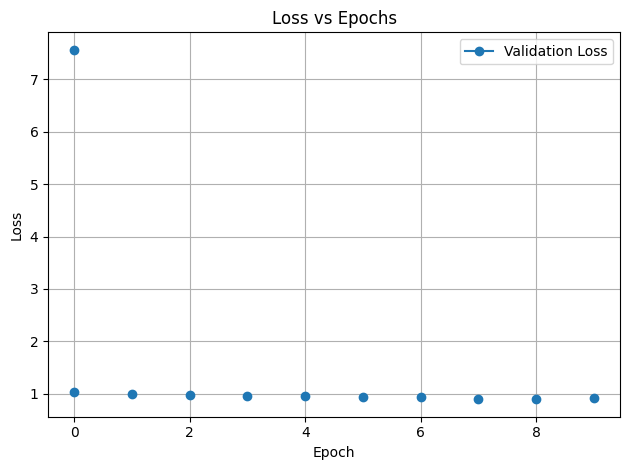

In [24]:
## Plotting validation loss (if logged)
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss', marker='o')

    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

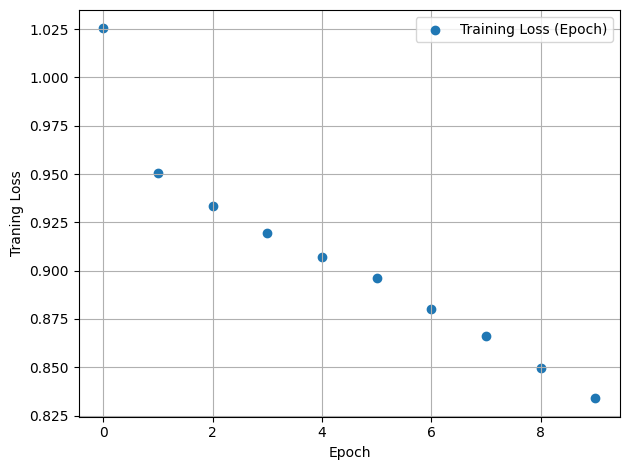

In [102]:
plt.scatter(metrics_df['epoch'], metrics_df['train_loss_epoch'], label='Training Loss (Epoch)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Traning Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

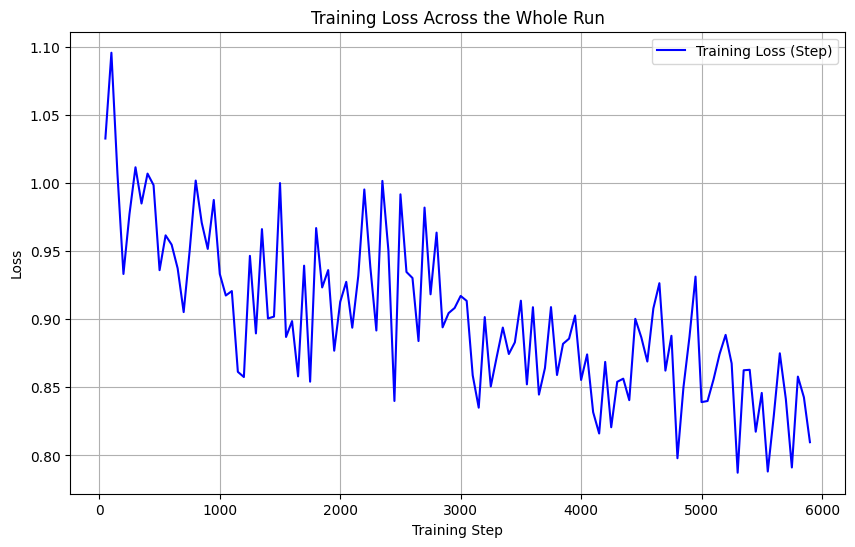

In [25]:
# plot training loss at each step
df_train = metrics_df.dropna(subset=['train_loss_step'])

plt.figure(figsize=(10, 6))
plt.plot(df_train['step'], df_train['train_loss_step'], label='Training Loss (Step)', color='blue')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Across the Whole Run')
plt.legend()
plt.grid(True)
plt.show()

## Run inference on held out sequences

In [26]:
preds = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8
    )
preds.shape

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.63it/s]


(13390, 15, 1)

In [27]:
preds_df = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8,
    return_df=True # Return the output as a pandas dataframe
    )
preds_df.head()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.64it/s]


,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
0,2.287378,2.185496,2.554604,2.461776,2.139232,2.218102,2.159050,2.055662,2.228493,2.264052,2.466351,2.084469,2.894904,2.114880,2.410789
1,1.948393,1.849066,1.999329,1.926863,1.961717,1.878543,1.848438,1.941527,1.940781,1.890582,1.909304,2.056766,2.042186,1.913879,1.955152
2,1.633824,1.441574,1.632096,1.543468,1.786043,1.698700,1.610143,1.785499,1.732721,1.561996,1.472180,1.898378,1.686928,1.643003,2.363239
3,2.591313,2.351555,2.529876,2.560392,2.356230,2.586692,2.508635,2.204630,2.566044,2.690799,2.619775,2.338428,2.543217,2.410444,2.503648
4,2.717038,2.855979,2.661363,2.741569,2.524162,2.633785,2.677896,2.551074,2.695457,2.803629,2.725083,2.443843,2.621725,2.692882,2.411244


## Correlations for each cell type in test set

In [28]:
test_metrics.sort_values(by = 'test_pearson', ascending= False)

,test_mse,test_pearson
primary neuron,0.934402,0.490777
central nervous system,1.108382,0.485079
neural stem cell,1.061237,0.477654
neural keel,0.964143,0.477420
forebrain,0.971863,0.470405
mesenchyme cell,1.072113,0.463668
lateral plate mesoderm,0.937913,0.447106
immature eye,1.033189,0.444023
YSL,0.871131,0.433787
anterior/posterior axis,0.980991,0.427510


In [29]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

## Inpsecting the performance of the trained model

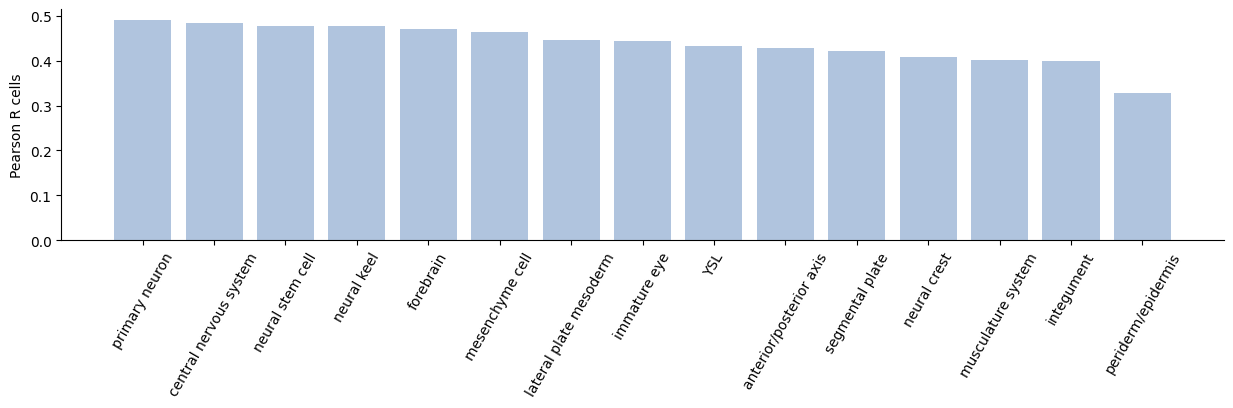

In [30]:
from plotlib import _bar_plot
import matplotlib.pyplot as plt

corrvalues_sorted = test_metrics.sort_values(by = 'test_pearson', ascending= False)

ax = _bar_plot(corrvalues_sorted['test_pearson'], ylabel = 'Pearson R cells', horizontal = False, xticklabels = corrvalues_sorted.index, rotation = 60)
plt.show()

## Interpreting model predictions and attributions for neural crest cells

**Note**: We want to find out what the model thinks that is important in the sequence to get a high signal.
grelu has a few methods that you can easily select (saliency, integratedgradients, and deepliftshap)
However, you won't be able to use deepliftshap if you trained a model with GELU or with attention

### Model performance for neural crest cell

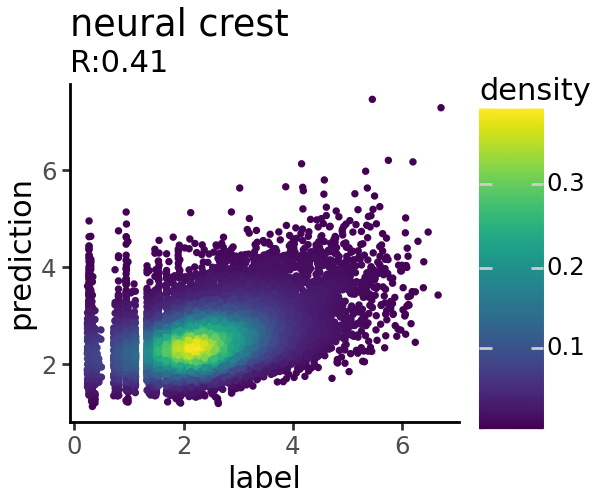

In [53]:
import grelu.visualize
%matplotlib inline
import plotnine as p9
from scipy.stats import pearsonr

fig = grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    tasks= [8],
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)



pcorr = str(round(test_metrics['test_pearson'].values[8], 2))
fig + p9.labs(title = f'{ad.obs_names[8]}',
              subtitle = f'R:{pcorr}') 

### Plot performance of model on all cell types

In [32]:
# create list of predictions
n = preds.shape[1]
preds_list = [preds[:,e,:].reshape(-1) for e in range(n)]
len(preds_list)

15

In [33]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

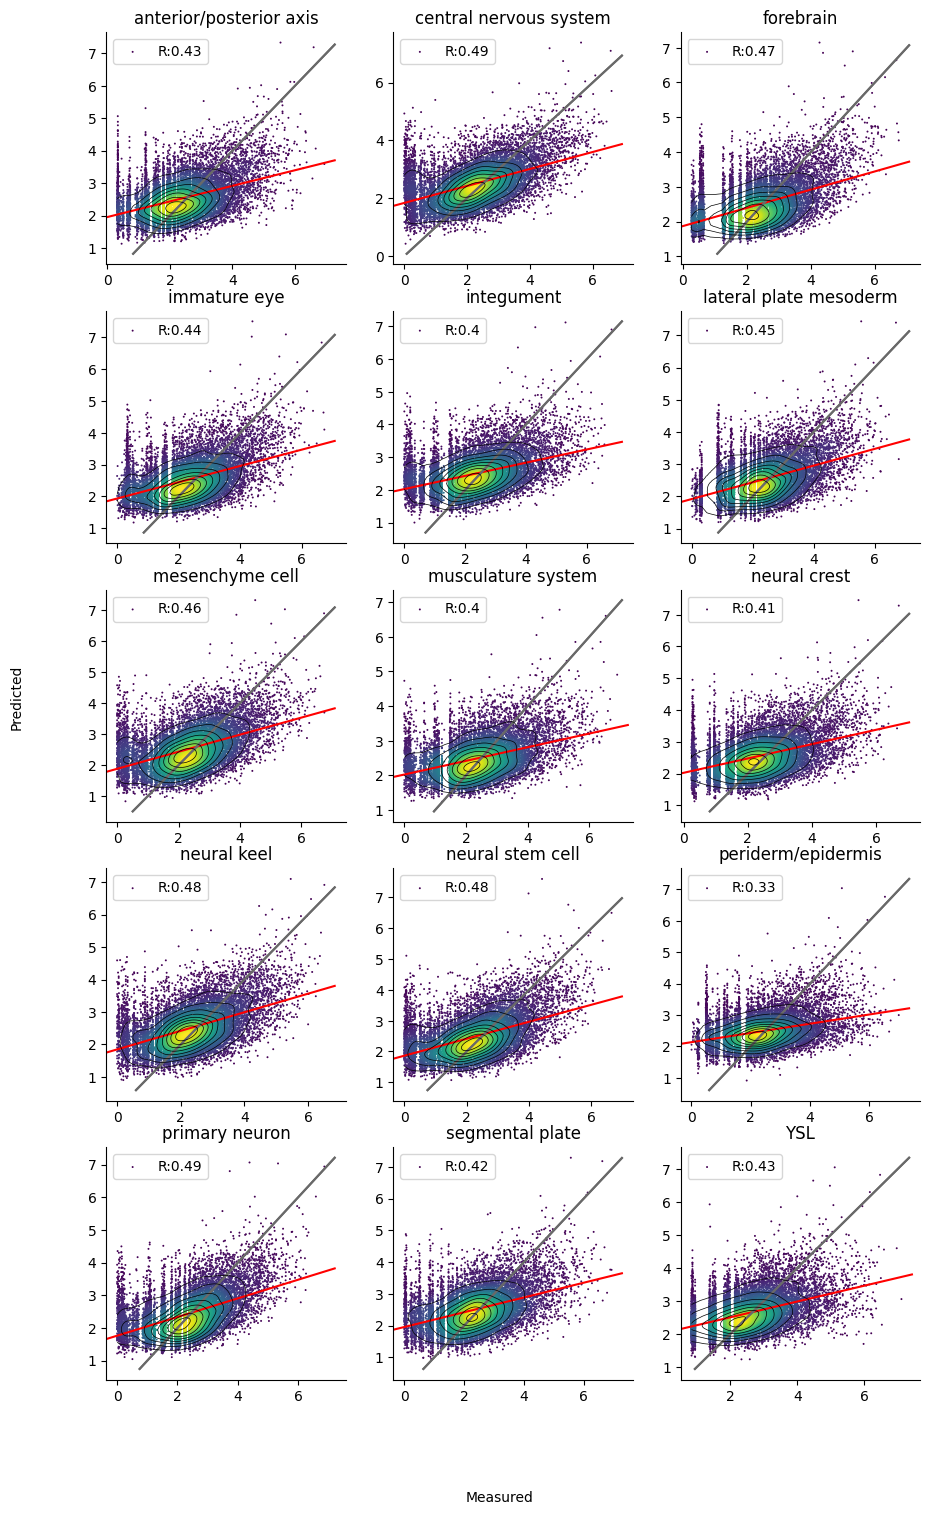

In [34]:
from plotlib import plot_scatter

allfig = plot_scatter(list(ad_test.X.toarray()), preds_list, titles = ad_test.obs_names, xlabel = 'Measured', ylabel = 'Predicted', 
                      sizes = 2, contour = True, color_density = True, color = 'grey', lw = 0., legend = True, 
                      include_fit = True, include_mainvar = False, diagonal = True)
plt.show()

### Selecting trusted well-predicted data points

In [63]:
# determine index for neural crest cell
nc_index = list(ad.obs_names).index('neural crest')
nc_index

8

In [72]:
# select sequence with highest signal and close to measured
nc_test_actual = list(ad_test.X.toarray())[nc_index]
nc_test_pred = preds_list[nc_index]
test_mask = (np.abs(nc_test_actual - nc_test_pred) < 1.) & (nc_test_pred > 6.)
print(f'Selected {int(np.sum(test_mask))} sequences for neural crest cells')

Selected 3 sequences for neural crest cells


In [73]:
# indices of sequences
selected_indices = ad_test.var[test_mask]
selected_indices

,chrom,start,end
49455,chr4,20623,21123
61678,chr4,72723283,72723783
62189,chr4,74929056,74929556


In [77]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    selected_indices,
    output_type="strings",
    genome=genome
)


len(input_seqs)

3

In [88]:
input_seqs

['ACCGGGCAGCGGGCACGAGCACTCGCCGGTAATCCCTCGCCGATCAAACGCTTTGATTTCTCCTCAGAATCGACTTTTCACAGTGTAATAAAGCGCGCGCCCCTCCCTGCGGCTGCCACACACACACACTCGCACACTGCCGGACCGCCCGAGCCCCGCTGCCGACGCCCCGCCCCTCACCGCTCCCCTCACTCTGATTGGACAGCGGCCGGGACCTCCGCGACGGTGATTGGAGGAGCAGTCGCTTCACTCAAACGCATCCTCGGATTTCTGGTTCCTGACTGTCGGGACCGGCTGTCAATCAGAGGTTCCCCCTGAGCTTCTCTGCGATTGGCCGAGCCCGCTCCCGCCCTCTGCCTGAGCCAGGTTAGCCCCGCCTCTTCCGCGCTGACATCCGGGCTCTTTCAGCGCGTCACCGTCAGCGCATTGTCTCCGCGTTTGCGTGTAAATCCGTAACCCTGACGAGCAGCGAGAGAGCTGATCAACCGATCACCAGCAGC',
 'CTGAACAGTTAGACCGACTGTGATTTGATTTACTTTAGATTAAAAAAAAAACACATTTTTATTAATAACGTTACCTTGGTCCACGTTTTATCCCGAAATACTTTACAGCGCCTGCGTGAGCCGGCCTGAGCCTCCGCCTAATCTGACAGGAGGGTAGTTGTTGGTTGACCAGTCCTACTATGGCGAGCATTTACCTCGTGAAATATTAATTAGGTAACGTATTAGTCGATTAACTGCCCTCTGATTGGCTGAAAGGCAGCGGTTGGTAGGCGGGCGTTGAGTAGGCGACGAATAAACAAACGACAGTACTGTCTTATGAATATTAATTGAACGACGTGCGTGGAACGCACCTGAGAGACGTCAGGGCGACCTTATTAATATTCATGAGCTAAACCGTCGCAATAGTAGGGACCGTATTTCTCCCAACATCACAATCATGAAGCGGGATGGTGGCAGCCGGTGGCTCTGTCGTGTCTTTGTCTGGCCCGGGTTA

In [89]:
len(input_seqs[0])

500

In [76]:
input_seqs[0][:10]

'ACCGGGCAGC'

### Forward propagation of influence using integrated gradients

In [78]:
from grelu.transforms.prediction_transforms import Aggregate

neural_crest_peaks = Aggregate(
    tasks = ["neural crest"],
    model = model,
)

neural_crest_peaks

Aggregate()

In [79]:
import grelu.interpret.score

attrs = grelu.interpret.score.get_attributions(
    model, input_seqs, prediction_transform=neural_crest_peaks, device=0,
    method="integratedgradients",
)

In [82]:
attrs.shape

(3, 4, 500)

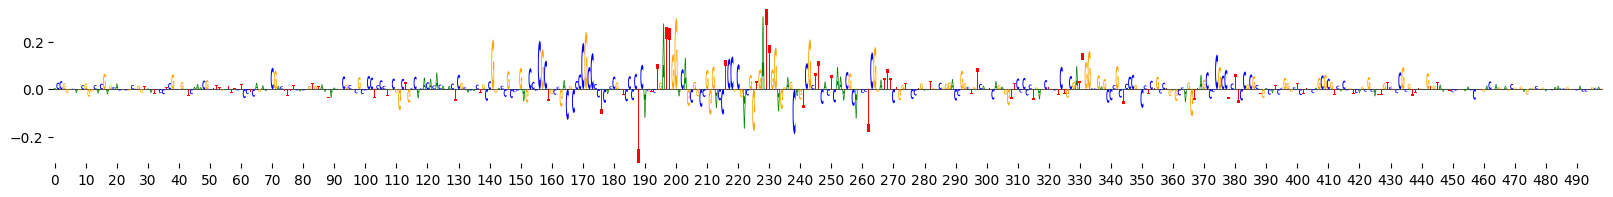

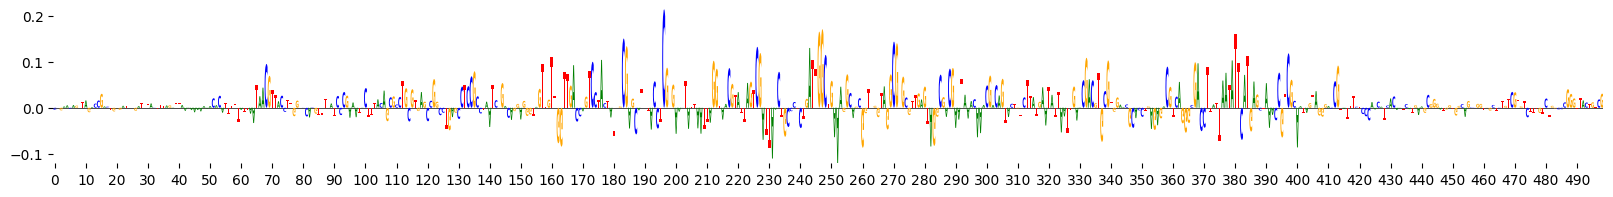

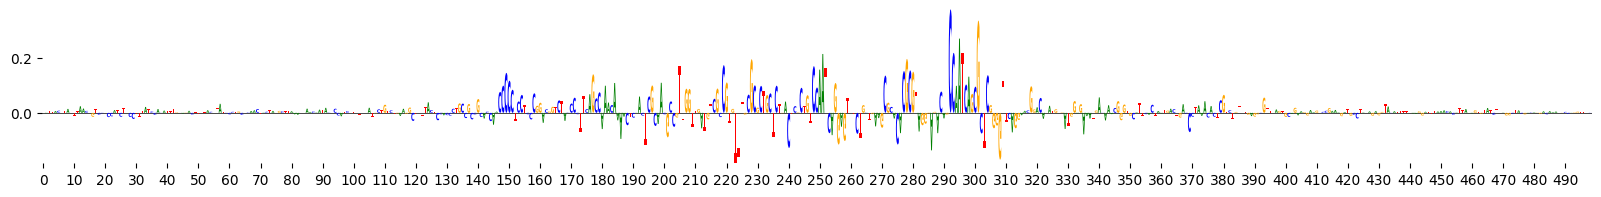

In [92]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

### Using integrated gradients from Captum

In [ ]:
from utils import get_captum_integrated_gradients


captum_attrs = get_captum_integrated_gradients(
    model, input_seqs, genome, prediction_transform=neural_crest_peaks, device=0,
    multiply_by_inputs= True,
)

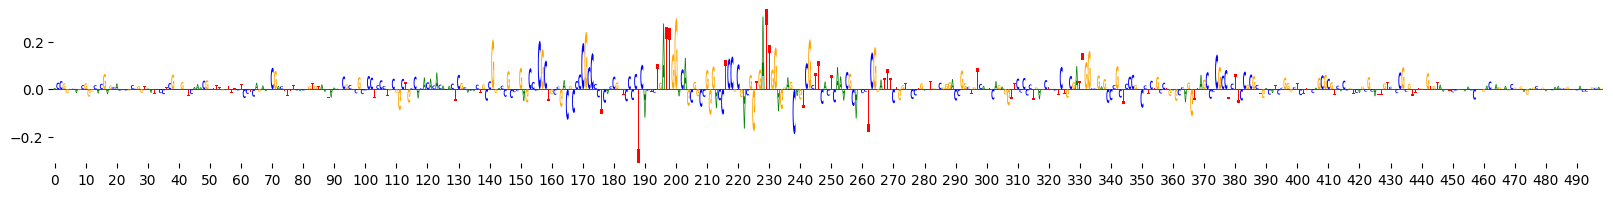

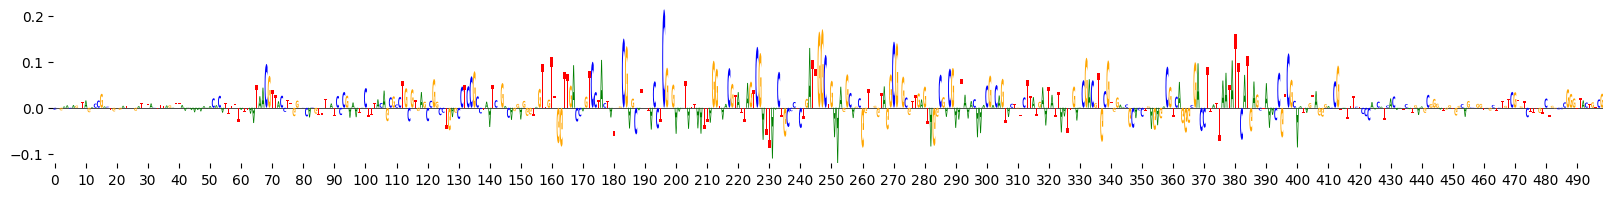

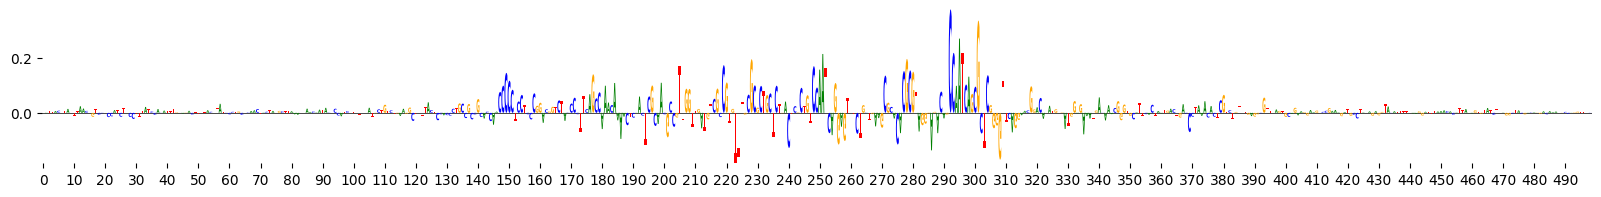

In [95]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        captum_attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

In [ ]:
captum_attrs = get_captum_integrated_gradients(
    model, input_seqs, genome, prediction_transform=neural_crest_peaks, device=0,
    multiply_by_inputs= False,
)

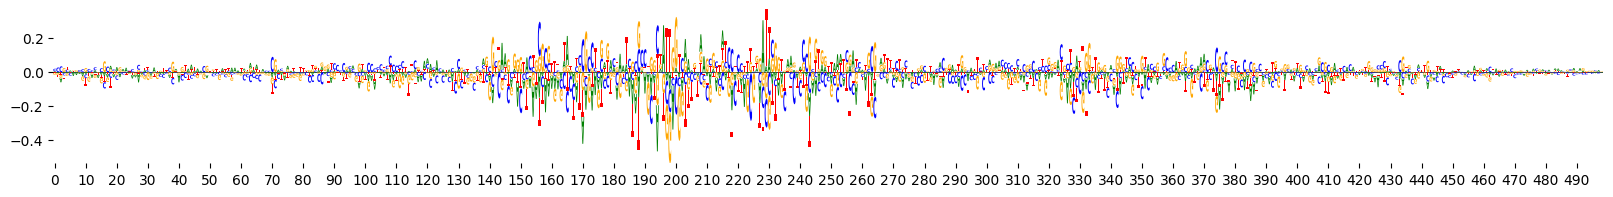

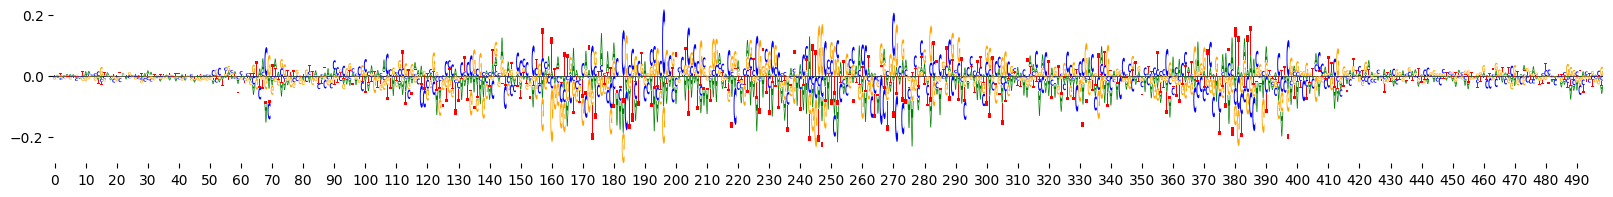

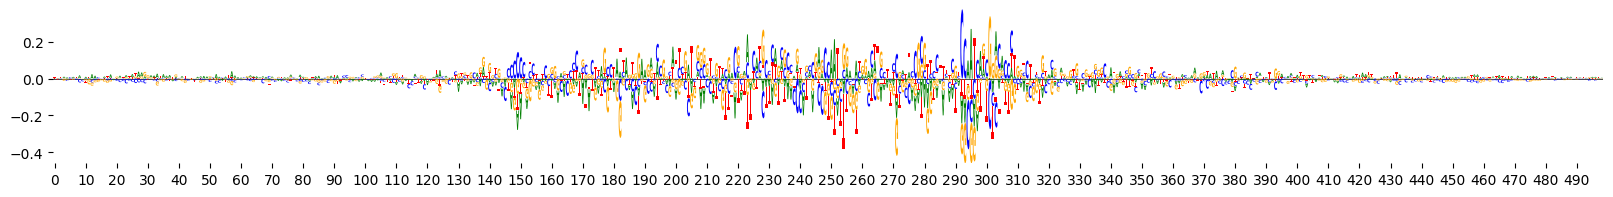

In [98]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        captum_attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

In [99]:
captum_attrs.shape

(3, 4, 500)

### Systematically extract motifs from the computed sequence attributions

In [196]:
test_actual = np.array(list(ad_test.X.toarray()))
test_pred = np.array(preds_list)
test_mask_motifs = (np.abs(test_actual - test_pred) < 1.) * (test_pred > 5.)
print(f'Selected {int(np.sum(test_mask_motifs))} sequences that differ at most 1 in cell types where they have signal over 5')

Selected 275 sequences that differ at most 1 in cell types where they have signal over 5


In [197]:
np.sum(test_mask_motifs, axis= 1)

array([21, 30, 18, 24, 12, 20, 26, 10, 18, 23, 21,  7, 14, 16, 15])

In [198]:
test_mask_motifs.shape

(15, 13390)

In [233]:
selected_indices_per_cell = [ad_test.var[test_mask_motifs[cell_index]] for cell_index in  range(test_mask_motifs.shape[0])]
selected_indices_per_cell[0]

,chrom,start,end
49455,chr4,20623,21123
49459,chr4,28154,28654
49520,chr4,119542,120042
49549,chr4,158096,158596
49577,chr4,211708,212208
49579,chr4,214350,214850
52075,chr4,6833227,6833727
52178,chr4,7222174,7222674
53175,chr4,9911276,9911776
53386,chr4,10603896,10604396


In [200]:
selected_seqs = {}

for e in range(len(selected_indices_per_cell)):
    cell_type = ad_test.obs_names[e]
    selected_indices = selected_indices_per_cell[e]
    selected_seqs[cell_type] = grelu.sequence.format.convert_input_type(
        selected_indices,
        output_type="strings",
        genome=genome
)


selected_seqs['neural crest']

['ACCGGGCAGCGGGCACGAGCACTCGCCGGTAATCCCTCGCCGATCAAACGCTTTGATTTCTCCTCAGAATCGACTTTTCACAGTGTAATAAAGCGCGCGCCCCTCCCTGCGGCTGCCACACACACACACTCGCACACTGCCGGACCGCCCGAGCCCCGCTGCCGACGCCCCGCCCCTCACCGCTCCCCTCACTCTGATTGGACAGCGGCCGGGACCTCCGCGACGGTGATTGGAGGAGCAGTCGCTTCACTCAAACGCATCCTCGGATTTCTGGTTCCTGACTGTCGGGACCGGCTGTCAATCAGAGGTTCCCCCTGAGCTTCTCTGCGATTGGCCGAGCCCGCTCCCGCCCTCTGCCTGAGCCAGGTTAGCCCCGCCTCTTCCGCGCTGACATCCGGGCTCTTTCAGCGCGTCACCGTCAGCGCATTGTCTCCGCGTTTGCGTGTAAATCCGTAACCCTGACGAGCAGCGAGAGAGCTGATCAACCGATCACCAGCAGC',
 'GCTGTGCCGCCCGCAGCTGTCAATCAAAGTGCGGTTCTGTTTCCGGGTTGTCTCGGATGTTTGGCATATCGGTGTCTATGGAAACACGGGTCAGACGGACGCGGGCTCAGACCTCCGTGTGTTTTGTCTCCGTTGATTTCGGCTGGGAAATCGTTAAAAACACCGGCAGGTCCGATAGACCGTGAGGCGTCATAGCAGCGGTGTGTCCGCTAGAGGGAGACTCTTTCTCTCTCTCACACACACACACACACACACACACACACACACGCACACACATTAGACTCTTCTGCGCATGATCAGCTCTGCTCCGGTCGCTCATCTTCATGCTGCCGTTAACGGCGCTCGGTAGGACTCCTCACCGCTCGTGAGCTGCTCTTCTTCTGCTGCTCGTTGTGTGTGAACGCCGCTGTTCGAGGATTATTCGCCGGTAACGCGGATCTAAAGCGGAGAAACGGGCAAAGGAATAACGACACCGACAGCACGGGCGATCGGC

In [201]:
len(selected_seqs['neural crest'])

18

In [202]:
list(selected_seqs.keys())

['anterior/posterior axis',
 'central nervous system',
 'forebrain',
 'immature eye',
 'integument',
 'lateral plate mesoderm',
 'mesenchyme cell',
 'musculature system',
 'neural crest',
 'neural keel',
 'neural stem cell',
 'periderm/epidermis',
 'primary neuron',
 'segmental plate',
 'YSL']

In [193]:
cell_type_lists = list(selected_seqs.keys())
ig_attrs = {}

for cell_type in cell_type_lists:
    cell_atac_peaks = Aggregate(
        tasks = [cell_type],
        model = model,
    )

    input_seqs = selected_seqs[cell_type]
    prediction_transform=cell_atac_peaks

    ig_attrs[cell_type] = get_captum_integrated_gradients(
        model, input_seqs, genome, prediction_transform=prediction_transform, device=0,
        multiply_by_inputs= False,
    )

In [194]:
ig_attrs['neural crest'].shape

(18, 4, 500)

In [206]:
ig_attrs['neural crest'][0]

array([[ 0.00563546, -0.00492163, -0.02451787, ...,  0.01007489,
        -0.00309397, -0.00880197],
       [ 0.01433771,  0.0274162 ,  0.03431093, ..., -0.00934288,
        -0.00084692,  0.00513384],
       [-0.01384983, -0.01232189, -0.01961366, ...,  0.0018655 ,
         0.0032867 , -0.00631793],
       [-0.00226154, -0.01392834, -0.01568895, ...,  0.00039442,
         0.00136448,  0.00525557]])

In [225]:
sds = [np.std(ig_attrs[cell_type], axis = (-1,-2)) for cell_type in list(selected_seqs.keys())]

In [226]:
len(sds)

15

In [229]:
sds[0]

array([0.05468967, 0.0324025 , 0.04271115, 0.02990478, 0.03795897,
       0.04612305, 0.04007854, 0.04176425, 0.04121475, 0.03584215,
       0.03675954, 0.04049748, 0.03858076, 0.04155811, 0.03965994,
       0.03409349, 0.0420633 , 0.05251076, 0.0396124 , 0.04773637,
       0.03007068])

In [230]:
len(sds[0])

21

In [218]:
ig_attrs['neural crest'].shape

(18, 4, 500)

### From local propagation results to global interpretation

The regulatory motifs for Zebra fish (Danio Rerio) were obtained from the [`SwissRegulon Portal`](https://swissregulon.unibas.ch/data/dr11/dr11_weight_matrices) as produced by the publication:

Baranasic, D., Hörtenhuber, M., Balwierz, P.J. et al. Multiomic atlas with functional stratification and developmental dynamics of zebrafish cis-regulatory elements. Nat Genet 54, 1037–1050 (2022). https://doi.org/10.1038/s41588-022-01089-w

Furthermore, the regulatory motifs (weight matrices) was converted from its original TRANSFAC 'matrix.dat' file into a MEME motif file by using the `transfac2meme` motif conversion utility from the [`The MEME Suite`](https://web.mit.edu/meme_v4.11.4/share/doc/transfac2meme.html).



In [241]:
%%time
import grelu.interpret.modisco

nc_index = list(ad.obs_names).index('neural crest')
neural_crest_test_seqs = ad_test.var[test_mask_motifs[nc_index]]

grelu.interpret.modisco.run_modisco(
    model,
    seqs=neural_crest_test_seqs, 
    genome=genome,
    prediction_transform=neural_crest_peaks, # Base importance scores will be calculated with respect to this output
    meme_file="../data/danRer11.meme", # Path to a MEME file containing reference motifs for TOMTOM
    method="deepshap", # Either “deepshap”, “saliency” or “ism”
    out_dir=experiment,
    batch_size=64,
    devices=0,
    num_workers=8,
    window=100, #Sequence length over which to consider attributions
    seed=0,
)

Getting attributions


/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([[1.2228e-03, 1.4618e-01, 3.1548e-01,  ..., 1.5308e+00, 9.6332e-01,
         2.3584e-01],
        [1.4875e-01, 1.3425e-03, 4.6300e-01,  ..., 1.3833e+00, 8.1580e-01,
         8.8313e-02],
        [3.1285e-01, 4.6025e-01, 1.4071e-03,  ..., 1.8449e+00, 1.2774e+00,
         5.4991e-01],
        ...,
        [1.5329e+00, 1.3855e+00, 1.8472e+00,  ..., 9.0718e-04, 5.6840e-01,
         1.2959e+00],
        [9.6564e-01, 8.1823e-01, 1.2799e+00,  ..., 5.6640e-01, 1.0958e-03,
         7.2858e-01],
        [2.3850e-01, 9.1094e-02, 5.5275e-01,  ..., 1.2935e+00, 7.2604e-01,
         1.4384e-03]], device='cuda:0', grad_fn=<AbsBackward0>)
/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([[1.4622e-03, 9.9680e-01, 4.4733e-01,  ..., 

Running modisco
Writing modisco output
Creating sequence logos
Creating html report
Running TOMTOM
CPU times: user 10.4 s, sys: 26 ms, total: 10.5 s
Wall time: 428 ms


/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([[1.2414e-03, 7.8921e-01, 4.0185e-01,  ..., 5.4372e-01, 6.6517e-01,
         8.3737e-01],
        [7.8655e-01, 1.4138e-03, 1.1896e+00,  ..., 2.4407e-01, 1.2262e-01,
         4.9578e-02],
        [4.0402e-01, 1.1920e+00, 9.3031e-04,  ..., 9.4650e-01, 1.0680e+00,
         1.2402e+00],
        ...,
        [5.4126e-01, 2.4670e-01, 9.4436e-01,  ..., 1.2167e-03, 1.2267e-01,
         2.9487e-01],
        [6.6293e-01, 1.2504e-01, 1.0660e+00,  ..., 1.2045e-01, 1.0023e-03,
         1.7320e-01],
        [8.3474e-01, 4.6777e-02, 1.2378e+00,  ..., 2.9226e-01, 1.7081e-01,
         1.3874e-03]], device='cuda:0', grad_fn=<AbsBackward0>)
/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([[1.3795e-03, 2.0492e-01, 9.7684e-01,  ..., 

In [236]:
neural_crest_peaks

Aggregate()